In this first part, we run the simulation for a given time series length (n_samples), minTP, and bootstrap_length.
We plot the simulated time series and the correlation matrices for the original time series, the reordered time series (simply to show that it is identical to the original), the reordered time series truncated to minTP, and the averaged bootstrap correlation matrix
We also plot the differences between these matrices

One thing to note is that large movements will artificially increase correlations, so when you examine the correlation between the original and truncated or bootstrapped time series, it may be relatively low.

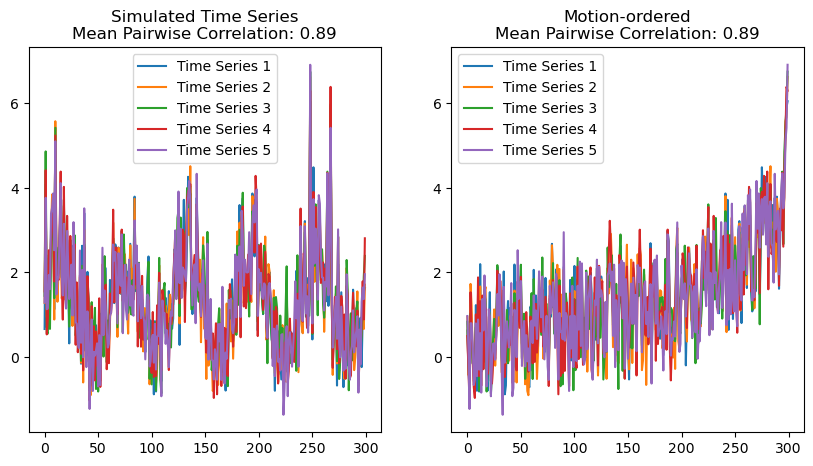

Text(0.5, 0.95, 'Original Time Series length = 300, MinTP = 120, Bootstrap Length = 60')

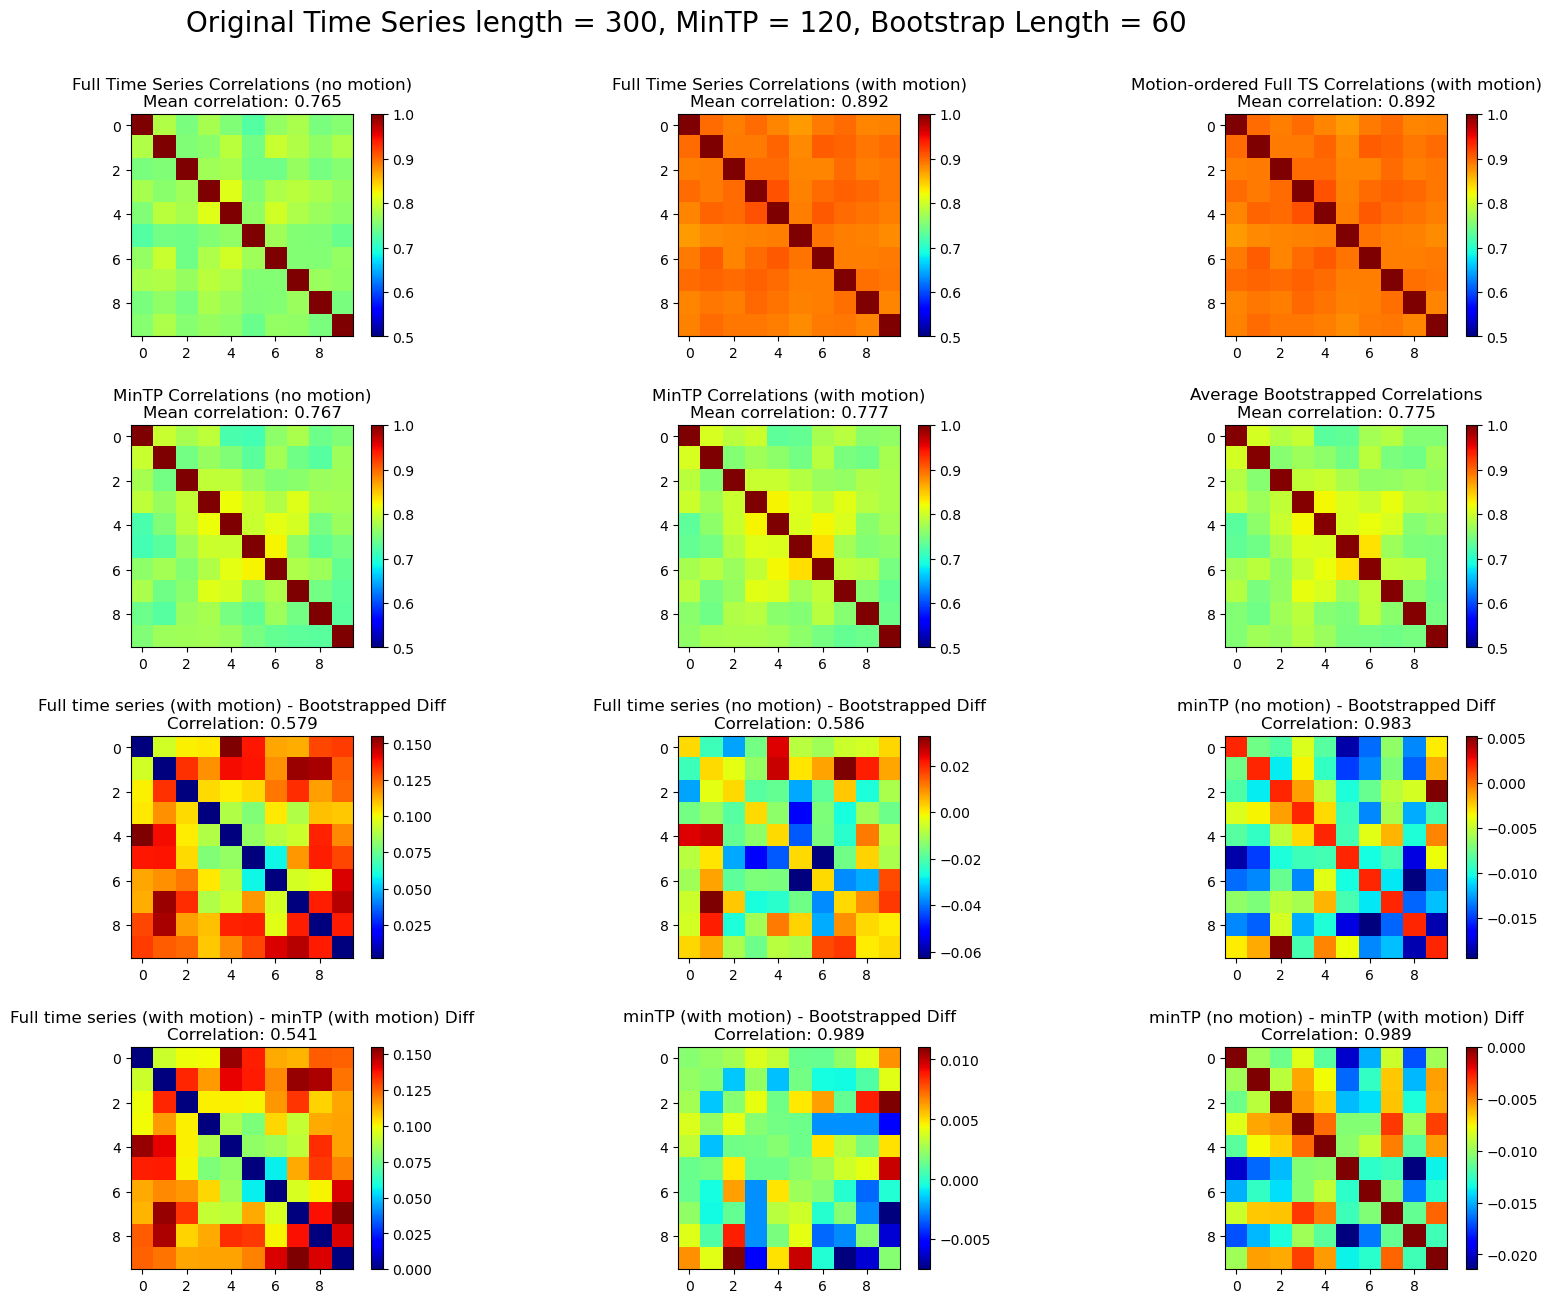

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem


# Parameters
n_series = 10 #Number of time series to simulate
n_samples = 300 #Number of time points
n_cycles = n_samples/30 #number of sine wave cycles in simulation
noisiness = 0.4 #How noisy to make random noise added to time series
motion_noisiness = 0.6 #How noisy to make motion added to time series
small_movement_prob = 0.97 #Probability of small movements in motion time series
large_movement_prob = 0.03 #Probability of large movements in motion time series
motion_weight = 0.7 #How much to weigh motion when adding to fMRI time series
n_bootstrap = 500 #Number of bootstrap samples
minTP = 120 #Length of time series retained after sorting by motion
bootstrap_length = 60 #Number of time points sampled from minTP in bootstrap


# Simluate a toy resting-state signal
def generate_resting_state_fmri(n_samples, n_cycles, noisiness):
    signal = np.sin(np.linspace(0, n_cycles * np.pi, n_samples))
    #signal2 = np.sin(np.linspace(0, n_cycles/-4 * np.pi, n_samples))
    #signal = signal + signal2
    
    # Add noise
    noise = np.random.normal(0, noisiness, n_samples)
    time_series = signal + noise

    return time_series

# Generate a set of simulated signals
def generate_resting_state_fmri_set(n_series, n_samples, n_cycles, noisiness):
    time_series_set = []
    for _ in range(n_series):
        time_series_set.append(generate_resting_state_fmri(n_samples, n_cycles, noisiness))
    return np.array(time_series_set)

#Simulate head motion parameters
def generate_head_motion_parameters(n_samples, small_movement_prob, large_movement_prob, noisiness):
    # Generate head motion parameters with mostly small movements and occasional, isolated large movements
    translation_x = np.zeros(n_samples)
    translation_y = np.zeros(n_samples)
    translation_z = np.zeros(n_samples)
    rotation_x = np.zeros(n_samples)
    rotation_y = np.zeros(n_samples)
    rotation_z = np.zeros(n_samples)
    
    for i in range(1, n_samples):
        # Generate random number to determine movement type
        movement_type = np.random.choice(['small', 'large'], p=[small_movement_prob, large_movement_prob])

        # Generate small movement values
        small_translation = np.random.normal(0, noisiness)
        small_rotation = np.random.normal(0, noisiness)

        # Generate large movement values
        large_translation = np.random.normal(0, noisiness * 3)  # Large movement with higher noise
        large_rotation = np.random.normal(0, noisiness * 3)

        # Update head motion parameters
        if movement_type == 'small':
            translation_x[i] = translation_x[i-1] + small_translation
            translation_y[i] = translation_y[i-1] + small_translation
            translation_z[i] = translation_z[i-1] + small_translation
            rotation_x[i] = rotation_x[i-1] + small_rotation
            rotation_y[i] = rotation_y[i-1] + small_rotation
            rotation_z[i] = rotation_z[i-1] + small_rotation
        else:
            translation_x[i] = translation_x[i-1] + large_translation
            translation_y[i] = translation_y[i-1] + large_translation
            translation_z[i] = translation_z[i-1] + large_translation
            rotation_x[i] = rotation_x[i-1] + large_rotation
            rotation_y[i] = rotation_y[i-1] + large_rotation
            rotation_z[i] = rotation_z[i-1] + large_rotation

    return translation_x, translation_y, translation_z, rotation_x, rotation_y, rotation_z

#Use simulated head motion to compute FD timeseries
def calculate_framewise_displacement(translation_x, translation_y, translation_z, rotation_x, rotation_y, rotation_z):
    # Calculate framewise displacement (FD)
    fd = np.array([0])
    fd = np.append(fd, (np.abs(np.diff(translation_x)) +
                np.abs(np.diff(translation_y)) +
                np.abs(np.diff(translation_z)) +
                np.abs(np.diff(rotation_x)) +
                np.abs(np.diff(rotation_y)) +
                np.abs(np.diff(rotation_z))))
    fd[0]=fd[1:].mean() #replacing first fd value (0 by definition) with mean fd

    return fd

#Add simulated head motion to simulated fMRI time series
def add_motion_to_fmri(time_series, motion_time_series, motion_weight):
    time_series_with_motion = time_series + (motion_time_series * motion_weight)
    return time_series_with_motion

#Order fMRI timeseries according to motion, from least to most
def order_by_motion_set(time_series_set, motion_time_series):
    order = np.argsort(motion_time_series)
    ordered_time_series_set = time_series_set[:, order]

    return ordered_time_series_set

#Generate bootstrapped samples based on minTP & bootstrap sample length, compute correlations after each sample
def bootstrap_correlation_set(ordered_time_series_set, n_bootstrap, minTP, bootstrap_length):
    
    bootstrap_correlations_set = np.empty([ordered_time_series_set.shape[0],ordered_time_series_set.shape[0]])

    for _ in range(n_bootstrap-1):
        # Randomly sample indices for each bootstrap iteration
        bootstrap_indices = np.random.choice(minTP, bootstrap_length, replace=True)

        # Create the bootstrapped samples
        bootstrap_sample = ordered_time_series_set[:, bootstrap_indices]

        correlations = np.corrcoef(bootstrap_sample)
        np.array(correlations)

        bootstrap_correlations_set = np.dstack((bootstrap_correlations_set, correlations))
    
    return bootstrap_correlations_set



#Generate resting-state fMRI time series set
time_series_set = generate_resting_state_fmri_set(n_series, n_samples, n_cycles, noisiness)

#Generate head motion parameters
translation_x, translation_y, translation_z, rotation_x, rotation_y, rotation_z = \
generate_head_motion_parameters(n_samples, small_movement_prob, large_movement_prob, noisiness)

#Calculate framewise displacement (FD)
fd_time_series = calculate_framewise_displacement(translation_x, translation_y, translation_z,
                                              rotation_x, rotation_y, rotation_z)

#Add motion to time series
#Note that when there is a lot of motion/large movements, full correlation
#may be artificially inflated, and there may be large diff between orig and ordered time series
time_series_set_with_motion = add_motion_to_fmri(time_series_set, fd_time_series, motion_weight)

#Order time series set based on motion
ordered_time_series_set = order_by_motion_set(time_series_set_with_motion, fd_time_series)

#Order the no-motion time series too
ordered_no_motion_time_series_set = order_by_motion_set(time_series_set, fd_time_series)

#Compute pairwise correlations for original and reordered time series
#no motion
orig_correlations_no_motion = np.corrcoef(time_series_set)
mean_orig_no_motion_correlations = orig_correlations_no_motion[np.tril_indices(n_series, k=-1)].mean()
#with motion
orig_correlations = np.corrcoef(time_series_set_with_motion)
mean_orig_correlations = orig_correlations[np.tril_indices(n_series, k=-1)].mean()
#reordered
reordered_correlations = np.corrcoef(ordered_time_series_set)
mean_reordered_correlations = reordered_correlations[np.tril_indices(n_series, k=-1)].mean()
#reordered minTP - matched in terms of time series length
reordered_minTP_correlations = np.corrcoef(ordered_time_series_set[:, 0:minTP-1])
mean_reordered_minTP_correlations = reordered_minTP_correlations[np.tril_indices(n_series, k=-1)].mean()
#reordered no motion minTP - matched in terms of time series length
reordered_no_motion_minTP_correlations = np.corrcoef(ordered_no_motion_time_series_set[:, 0:minTP-1])
mean_reordered_no_motion_minTP_correlations = reordered_no_motion_minTP_correlations[np.tril_indices(n_series, k=-1)].mean()

#Bootstrap correlation set
bootstrap_correlations_set = bootstrap_correlation_set(ordered_time_series_set, n_bootstrap, minTP, bootstrap_length)
mean_bootstrap_correlations = bootstrap_correlations_set.mean(axis=2)

#Compute mean correlation and 95% confidence interval across bootstrap samples
mean_bootstrap_corr = np.mean(bootstrap_correlations_set, axis=2)
ci_bootstrap_corr = np.percentile(bootstrap_correlations_set, [2.5, 97.5], axis=2)

overall_mean_bootstrap_corr = mean_bootstrap_corr[np.tril_indices(n_series, k=-1)].mean()

#Compute Differences
orig_nomotion_minus_bootstrap=orig_correlations_no_motion-mean_bootstrap_corr
orig_minus_bootstrap=orig_correlations-mean_bootstrap_corr
reordered_minTP_minus_bootstrap=reordered_minTP_correlations-mean_bootstrap_corr
orig_minus_reordered_minTP=orig_correlations-reordered_minTP_correlations
reordered_no_motion_minTP_minus_bootstrap=reordered_no_motion_minTP_correlations-mean_bootstrap_corr
reordered_no_motion_minTP_minus_reordered_minTP=reordered_no_motion_minTP_correlations-reordered_minTP_correlations

#Compute correlations between matrices
bootstrap_corr_orig_no_motion=np.corrcoef(orig_correlations_no_motion[np.tril_indices(n_series, k=-1)], mean_bootstrap_corr[np.tril_indices(n_series, k=-1)])[0,1]
bootstrap_corr_orig=np.corrcoef(orig_correlations[np.tril_indices(n_series, k=-1)], mean_bootstrap_corr[np.tril_indices(n_series, k=-1)])[0,1]
bootstrap_corr_reordered_minTP=np.corrcoef(reordered_minTP_correlations[np.tril_indices(n_series, k=-1)], mean_bootstrap_corr[np.tril_indices(n_series, k=-1)])[0,1]
orig_corr_reordered_minTP=np.corrcoef(orig_correlations[np.tril_indices(n_series, k=-1)], reordered_minTP_correlations[np.tril_indices(n_series, k=-1)])[0,1]
bootstrap_corr_reordered_no_motion_minTP=np.corrcoef(reordered_no_motion_minTP_correlations[np.tril_indices(n_series, k=-1)], mean_bootstrap_corr[np.tril_indices(n_series, k=-1)])[0,1]
reordered_minTP_corr_reordered_no_motion_minTP=np.corrcoef(reordered_no_motion_minTP_correlations[np.tril_indices(n_series, k=-1)], reordered_minTP_correlations[np.tril_indices(n_series, k=-1)])[0,1]

#Figures

#Plot the simulated time series
plt.figure(figsize=(10, 5))

#Original
plt.subplot(1, 2, 1)
plt.plot(time_series_set_with_motion[0,:], label='Time Series 1')
plt.plot(time_series_set_with_motion[1,:], label='Time Series 2')
plt.plot(time_series_set_with_motion[2,:], label='Time Series 3')
plt.plot(time_series_set_with_motion[3,:], label='Time Series 4')
plt.plot(time_series_set_with_motion[4,:], label='Time Series 5')
plt.title('Simulated Time Series\n' + r'Mean Pairwise Correlation: ' + str(mean_orig_correlations.round(2)))
#plt.title('My Title\n' + r'$\alpha - \omega$ are LaTeX Markup')
plt.legend()

#Ordered
plt.subplot(1, 2, 2)
plt.plot(ordered_time_series_set[0,:], label='Time Series 1')
plt.plot(ordered_time_series_set[1,:], label='Time Series 2')
plt.plot(ordered_time_series_set[2,:], label='Time Series 3')
plt.plot(ordered_time_series_set[3,:], label='Time Series 4')
plt.plot(ordered_time_series_set[4,:], label='Time Series 5')
plt.title('Motion-ordered\n' + r'Mean Pairwise Correlation: ' + str(mean_reordered_correlations.round(2)))
plt.legend()

plt.show()

#Plot the correlation matrices
plt.figure(figsize=(20, 15))
plt.tight_layout()

plt.subplot(4, 3, 1)
plt.imshow(orig_correlations_no_motion, cmap='jet', vmin=0.5, vmax=1)
plt.title('Full Time Series Correlations (no motion)\n' + r'Mean correlation: ' + str(mean_orig_no_motion_correlations.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 2)
plt.imshow(orig_correlations, cmap='jet', vmin=0.5, vmax=1)
plt.title('Full Time Series Correlations (with motion)\n' + r'Mean correlation: ' + str(mean_orig_correlations.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 3)
plt.imshow(reordered_correlations, cmap='jet', vmin=0.5, vmax=1)
plt.title('Motion-ordered Full TS Correlations (with motion)\n' + r'Mean correlation: ' + str(mean_reordered_correlations.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 4)
plt.imshow(reordered_no_motion_minTP_correlations, cmap='jet', vmin=0.5, vmax=1)
plt.title('MinTP Correlations (no motion)\n' + r'Mean correlation: ' + str(mean_reordered_no_motion_minTP_correlations.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 5)
plt.imshow(reordered_minTP_correlations, cmap='jet', vmin=0.5, vmax=1)
plt.title('MinTP Correlations (with motion)\n' + r'Mean correlation: ' + str(mean_reordered_minTP_correlations.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 6)
plt.imshow(mean_bootstrap_correlations, cmap='jet', vmin=0.5, vmax=1)
plt.title('Average Bootstrapped Correlations\n' + r'Mean correlation: ' + str(overall_mean_bootstrap_corr.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 7)
plt.imshow(orig_minus_bootstrap, cmap='jet', vmin=orig_minus_bootstrap.min(), vmax=orig_minus_bootstrap.max())
plt.title('Full time series (with motion) - Bootstrapped Diff\n' + r'Correlation: ' + str(bootstrap_corr_orig.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 8)
plt.imshow(orig_nomotion_minus_bootstrap, cmap='jet', vmin=orig_nomotion_minus_bootstrap.min(), vmax=orig_nomotion_minus_bootstrap.max())
plt.title('Full time series (no motion) - Bootstrapped Diff\n' + r'Correlation: ' + str(bootstrap_corr_orig_no_motion.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 9)
plt.imshow(reordered_no_motion_minTP_minus_bootstrap, cmap='jet', vmin=reordered_no_motion_minTP_minus_bootstrap.min(), vmax=reordered_no_motion_minTP_minus_bootstrap.max())
plt.title('minTP (no motion) - Bootstrapped Diff\n' + r'Correlation: ' + str(bootstrap_corr_reordered_no_motion_minTP.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 10)
plt.imshow(orig_minus_reordered_minTP, cmap='jet', vmin=orig_minus_reordered_minTP.min(), vmax=orig_minus_reordered_minTP.max())
plt.title('Full time series (with motion) - minTP (with motion) Diff\n' + r'Correlation: ' + str(orig_corr_reordered_minTP.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 11)
plt.imshow(reordered_minTP_minus_bootstrap, cmap='jet', vmin=reordered_minTP_minus_bootstrap.min(), vmax=reordered_minTP_minus_bootstrap.max())
plt.title('minTP (with motion) - Bootstrapped Diff\n' + r'Correlation: ' + str(bootstrap_corr_reordered_minTP.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(4, 3, 12)
plt.imshow(reordered_no_motion_minTP_minus_reordered_minTP, cmap='jet', vmin=reordered_no_motion_minTP_minus_reordered_minTP.min(), vmax=reordered_no_motion_minTP_minus_reordered_minTP.max())
plt.title('minTP (no motion) - minTP (with motion) Diff\n' + r'Correlation: ' + str(reordered_minTP_corr_reordered_no_motion_minTP.round(3)))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=0.4)

plt.suptitle('Original Time Series length = ' + str(n_samples) + r', MinTP = ' + str(minTP) + r', Bootstrap Length = '+ str(bootstrap_length), fontsize=20, y=0.95)



# Run a range of simulations

In this part, run the whole thing inside loops to examine range of minTP and bootstrap sample lengths, then plot these. 

I have only tried this for a range of bootstrap lenghts for a given minTP so far.

Not sure if this is valuable - would need to do it for a range of motion levels (low, med, high), as well as minTP - but there is a lot of variability in the simulation...


In [316]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem


# Parameter specification moved down 



# Simluate a toy resting-state signal
def generate_resting_state_fmri(n_samples, n_cycles, noisiness):
    signal = np.sin(np.linspace(0, n_cycles * np.pi, n_samples))
    signal2 = np.sin(np.linspace(0, n_cycles/-4 * np.pi, n_samples))
    signal = signal + signal2
    
    # Add noise
    noise = np.random.normal(0, noisiness, n_samples)
    time_series = signal + noise

    return time_series

# Generate a set of simulated signals
def generate_resting_state_fmri_set(n_series, n_samples, n_cycles, noisiness):
    time_series_set = []
    for _ in range(n_series):
        time_series_set.append(generate_resting_state_fmri(n_samples, n_cycles, noisiness))
    return np.array(time_series_set)

#Simulate head motion parameters
def generate_head_motion_parameters(n_samples, small_movement_prob, large_movement_prob, noisiness):
    # Generate head motion parameters with mostly small movements and occasional, isolated large movements
    translation_x = np.zeros(n_samples)
    translation_y = np.zeros(n_samples)
    translation_z = np.zeros(n_samples)
    rotation_x = np.zeros(n_samples)
    rotation_y = np.zeros(n_samples)
    rotation_z = np.zeros(n_samples)
    
    for i in range(1, n_samples):
        # Generate random number to determine movement type
        movement_type = np.random.choice(['small', 'large'], p=[small_movement_prob, large_movement_prob])

        # Generate small movement values
        small_translation = np.random.normal(0, noisiness)
        small_rotation = np.random.normal(0, noisiness)

        # Generate large movement values
        large_translation = np.random.normal(0, noisiness * 3)  # Large movement with higher noise
        large_rotation = np.random.normal(0, noisiness * 3)

        # Update head motion parameters
        if movement_type == 'small':
            translation_x[i] = translation_x[i-1] + small_translation
            translation_y[i] = translation_y[i-1] + small_translation
            translation_z[i] = translation_z[i-1] + small_translation
            rotation_x[i] = rotation_x[i-1] + small_rotation
            rotation_y[i] = rotation_y[i-1] + small_rotation
            rotation_z[i] = rotation_z[i-1] + small_rotation
        else:
            translation_x[i] = translation_x[i-1] + large_translation
            translation_y[i] = translation_y[i-1] + large_translation
            translation_z[i] = translation_z[i-1] + large_translation
            rotation_x[i] = rotation_x[i-1] + large_rotation
            rotation_y[i] = rotation_y[i-1] + large_rotation
            rotation_z[i] = rotation_z[i-1] + large_rotation

    return translation_x, translation_y, translation_z, rotation_x, rotation_y, rotation_z

#Use simulated head motion to compute FD timeseries
def calculate_framewise_displacement(translation_x, translation_y, translation_z, rotation_x, rotation_y, rotation_z):
    # Calculate framewise displacement (FD)
    fd = np.array([0])
    fd = np.append(fd, (np.abs(np.diff(translation_x)) +
                np.abs(np.diff(translation_y)) +
                np.abs(np.diff(translation_z)) +
                np.abs(np.diff(rotation_x)) +
                np.abs(np.diff(rotation_y)) +
                np.abs(np.diff(rotation_z))))
    fd[0]=fd[1:].mean() #replacing first fd value (0 by definition) with mean fd

    return fd

#Add simulated head motion to simulated fMRI time series
def add_motion_to_fmri(time_series, motion_time_series, motion_weight):
    time_series_with_motion = time_series + (motion_time_series * motion_weight)
    return time_series_with_motion

#Order fMRI timeseries according to motion, from least to most
def order_by_motion_set(time_series_set, motion_time_series):
    order = np.argsort(motion_time_series)
    ordered_time_series_set = time_series_set[:, order]

    return ordered_time_series_set

#Generate bootstrapped samples based on minTP & bootstrap sample length, compute correlations after each sample
def bootstrap_correlation_set(ordered_time_series_set, n_bootstrap, minTP, bootstrap_length):
    
    bootstrap_correlations_set = np.empty([ordered_time_series_set.shape[0],ordered_time_series_set.shape[0]])

    for _ in range(n_bootstrap-1):
        # Randomly sample indices for each bootstrap iteration
        bootstrap_indices = np.random.choice(minTP, bootstrap_length, replace=True)

        # Create the bootstrapped samples
        bootstrap_sample = ordered_time_series_set[:, bootstrap_indices]

        correlations = np.corrcoef(bootstrap_sample)
        np.array(correlations)

        bootstrap_correlations_set = np.dstack((bootstrap_correlations_set, correlations))
    
    return bootstrap_correlations_set



#
minTP = 100 #Length of time series retained after sorting by motion minTP_range = [60, 100, 150, 200]
bootstrap_length_range = [5, 10, 20, 40, 60] #, 80, 100, 120, 150] #[5, 10, 20, 40, 60, 80, 100, 120, 150]

n_series = 5 #Number of time series to simulate
n_samples = 300 #Number of time points
n_cycles = n_samples/30 #number of sine wave cycles in simulation
noisiness = 0.5 #How noisy to make random noise added to time series
motion_noisiness = 0.3 #How noisy to make motion added to time series
small_movement_prob = 0.98 #Probability of small movements in motion time series
large_movement_prob = 0.02 #Probability of large movements in motion time series
motion_weight = 0.3 #How much to weigh motion when adding to fMRI time series
n_bootstrap = 500 #Number of bootstrap samples


num_sims = 500

bootstrap_corr_orig=np.empty([num_sims,len(bootstrap_length_range)])
bootstrap_corr_reordered_minTP=np.empty([num_sims,len(bootstrap_length_range)])
orig_corr_reordered_minTP=np.empty([num_sims,len(bootstrap_length_range)])


for sim in range(num_sims-1):
    x=0
    for bootstrap_length in bootstrap_length_range: #Number of time points sampled from minTP in bootstrap

        #Generate resting-state fMRI time series set
        time_series_set = generate_resting_state_fmri_set(n_series, n_samples, n_cycles, noisiness)

        #Generate head motion parameters
        translation_x, translation_y, translation_z, rotation_x, rotation_y, rotation_z = \
        generate_head_motion_parameters(n_samples, small_movement_prob, large_movement_prob, noisiness)

        #Calculate framewise displacement (FD)
        fd_time_series = calculate_framewise_displacement(translation_x, translation_y, translation_z,
                                                      rotation_x, rotation_y, rotation_z)

        #Add motion to time series
        #Note that when there is a lot of motion/large movements, full correlation
        #may be artificially inflated, and there may be large diff between orig and ordered time series
        time_series_set_with_motion = add_motion_to_fmri(time_series_set, fd_time_series, motion_weight)

        #Order time series set based on motion
        ordered_time_series_set = order_by_motion_set(time_series_set_with_motion, fd_time_series)

        #Compute pairwise correlations for original and reordered time series
        orig_correlations = np.corrcoef(time_series_set_with_motion)
        mean_orig_correlations = orig_correlations[np.tril_indices(n_series, k=-1)].mean()

        reordered_correlations = np.corrcoef(ordered_time_series_set)
        mean_reordered_correlations = reordered_correlations[np.tril_indices(n_series, k=-1)].mean()

        reordered_minTP_correlations = np.corrcoef(ordered_time_series_set[:, 0:minTP-1])
        mean_reordered_minTP_correlations = reordered_minTP_correlations[np.tril_indices(n_series, k=-1)].mean()

        #Bootstrap correlation set
        bootstrap_correlations_set = bootstrap_correlation_set(ordered_time_series_set, n_bootstrap, minTP, bootstrap_length)
        mean_bootstrap_correlations = bootstrap_correlations_set.mean(axis=2)

        #Compute mean correlation and 95% confidence interval across bootstrap samples
        mean_bootstrap_corr = np.mean(bootstrap_correlations_set, axis=2)
        ci_bootstrap_corr = np.percentile(bootstrap_correlations_set, [2.5, 97.5], axis=2)

        overall_mean_bootstrap_corr = mean_bootstrap_corr[np.tril_indices(n_series, k=-1)].mean()

        #Compute Differences
        orig_minus_bootstrap=orig_correlations-mean_bootstrap_corr
        reordered_minTP_minus_bootstrap=reordered_minTP_correlations-mean_bootstrap_corr
        orig_minus_reordered_minTP=orig_correlations-reordered_minTP_correlations

        #Compute correlations between matrices
        bootstrap_corr_orig[sim,x]=np.corrcoef(orig_correlations[np.tril_indices(n_series, k=-1)], mean_bootstrap_corr[np.tril_indices(n_series, k=-1)])[0,1]
        bootstrap_corr_reordered_minTP[sim,x]=np.corrcoef(reordered_minTP_correlations[np.tril_indices(n_series, k=-1)], mean_bootstrap_corr[np.tril_indices(n_series, k=-1)])[0,1]
        orig_corr_reordered_minTP[sim,x]=np.corrcoef(orig_correlations[np.tril_indices(n_series, k=-1)], reordered_minTP_correlations[np.tril_indices(n_series, k=-1)])[0,1]

        x=x+1

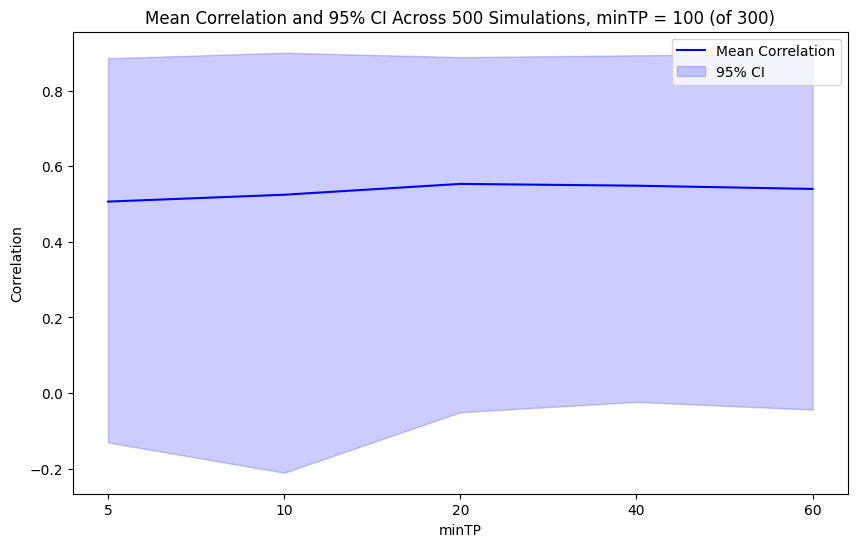

In [317]:
mean_bootstrap_corr_orig = bootstrap_corr_orig.mean(axis=0)
ci_bootstrap_corr = np.percentile(bootstrap_corr_orig, [2.5, 97.5], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_bootstrap_corr_orig, label='Mean Correlation', color='blue')
plt.fill_between(range(bootstrap_corr_orig.shape[1]),
                 ci_bootstrap_corr[0, :], ci_bootstrap_corr[1, :],
                 color='blue', alpha=0.2, label='95% CI')

plt.title('Mean Correlation and 95% CI Across 500 Simulations, minTP = 100 (of 300)')
#plt.xticks([range(0,len(bootstrap_length_range-1))], labels=bootstrap_length_range)
plt.xticks(np.arange(len(bootstrap_length_range)), bootstrap_length_range)
plt.xlabel('minTP')
plt.ylabel('Correlation')
plt.legend()
plt.show()